In [1]:
# python libraries
import time
import builtins
import sys
import numpy as np
import pandas as pd
import pydot
import matplotlib.pyplot as plt
from IPython.display import HTML, display, SVG

# pydrake imports
from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder, Linearize, 
    LinearQuadraticRegulator, LogVectorOutput,
    MeshcatVisualizer, ModelVisualizer, Parser, Simulator, 
    StartMeshcat, LeafSystem, MultibodyPlant, VectorSystem, PiecewisePolynomial, 
    MathematicalProgram, Solve, SnoptSolver, DirectCollocation, 
    MakeFiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulator, 
    FiniteHorizonLinearQuadraticRegulatorOptions,
    IpoptSolver, SolverOptions, GurobiSolver, CommonSolverOption, LeafSystem_,
    TemplateSystem, AutoDiffXd, SceneGraph, CollisionFilterDeclaration,
    CompositeTrajectory,
)
from underactuated.meshcat_utils import MeshcatSliders
from underactuated import running_as_notebook

# override print to automatically flush buffer
def print(*args, **kwargs):
    builtins.print(*args, **kwargs)
    sys.stdout.flush()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Constants #

In [3]:
g = 9.81
EPS = 1e-4

# lengths are in tens of meters
# mass is in millions of kg
rocket_m = 5
rocket_r = 0.6
rocket_h = 5
engine_thrust_lim = rocket_m * g * 2
engine_angle_lim = np.pi / 9  # falcon 9 gimbal angle is 5-10 degrees

engine_m = 0
engine_r = rocket_r
engine_h = 0.4

world_m = 1e10
world_h = 5
world_w = 100

pad_h = 2
pad_w = 2

# moments of inertia for rocket and engine
def calc_cylinder_moments(m, r, h):
    Ixx = m * (3 * r**2 + h**2) / 12
    Iyy = Ixx
    Izz = m * r**2 / 2
    return Ixx, Iyy, Izz

engine_Ixx, engine_Iyy, engine_Izz = calc_cylinder_moments(engine_m, engine_r, engine_h)
rocket_Ixx, rocket_Iyy, rocket_Izz = calc_cylinder_moments(rocket_m, rocket_r, rocket_h)

# URDF #

In [4]:
def mk_rocket_urdf():
    '''
    Make URDF for rocket and world using global constants.
    '''

    ## Links ##

    # landing pad
    pad_link = f"""
        <link name="pad">
            <visual>
                <origin xyz="0 0 -{pad_h / 2}" rpy="0 0 0"/>
                <geometry>
                    <box size="{pad_w} {pad_w} {pad_h}"/>
                </geometry>
                <material>
                    <color rgba="0.8 0.8 0.8 1"/>
                </material>
            </visual>
        </link>
    """

    # ground
    world_link = f"""
        <link name="world">
            <visual>
                <origin xyz="0 0 {-world_h / 2 - pad_h}" rpy="0 0 0"/>
                <geometry>
                    <box size="{world_w} {world_w} {world_h}"/>
                </geometry>
                <material>
                    <color rgba="0 0.5 0 1"/>
                </material>
            </visual>
        </link>
    """

    # virtual link 1 to allow horizontal movement
    virtual_link = f"""
        <link name="virtual">
            <inertial>
                <origin xyz="0 0 {rocket_h / 2}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 {rocket_h / 2}"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0.5 0.5 0.5 0"/>
                </material>
            </visual>
        </link>
    """

    # virtual link 2 to allow vertical movement
    virtual_link2 = f"""
        <link name="virtual2">
            <inertial>
                <origin xyz="0 0 {rocket_h / 2}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 {rocket_h / 2}"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0 0 1 0"/>
                </material>
            </visual>
        </link>
    """

    # rocket's body
    rocket_link = f"""
        <link name="rocket">
            <inertial>
                <origin xyz="0 0 0"/>
                <mass value="{rocket_m}"/>
                <inertia ixx="{rocket_Ixx}" iyy="{rocket_Iyy}" izz="{rocket_Izz}"/>
            </inertial>

            <visual>
                <origin xyz="0 0 0"/>
                <geometry>
                    <cylinder length="{rocket_h}" radius="{rocket_r}"/>
                </geometry>
                <material>
                    <color rgba="0 0 0 1"/>
                </material>
            </visual>
        </link>
    """

    # rocket's engine which produces thrust
    engine_link = f"""
        <link name="engine">
            <inertial>
                <origin xyz="0 0 {engine_h / 2}"/>
                <mass value="{engine_m}"/>
                <inertia ixx="{engine_Ixx}" iyy="{engine_Iyy}" izz="{engine_Izz}"/>
            </inertial>
            
            <visual>
                <origin xyz="0 0 {engine_h / 2}"/>
                <geometry>
                    <cylinder length="{engine_h}" radius="{engine_r}"/>
                </geometry>
                <material>
                    <color rgba="1 0 0 1"/>
                </material>
            </visual>
        </link>
    """


    ## Joints ##
    # state is defined by joints and is 
    # X = [q, q_dot], where q = [x, y, theta]

    # fixes pad to world
    pad_joint = f"""
        <joint name="pad_joint" type="fixed">
            <parent link="world"/>
            <child link="pad"/>
            <origin xyz="0 0 0"/>
        </joint>
    """

    # allows rocket to move horizontally
    x_joint = f"""
        <joint name="x_joint" type="prismatic">
            <parent link="world"/>
            <child link="virtual"/>
            <origin xyz="0 0 0"/>
            <axis xyz="1 0 0"/>
        </joint>
    """

    # allows rocket to move horizontally
    y_joint = f"""
        <joint name="y_joint" type="prismatic">
            <parent link="virtual"/>
            <child link="virtual2"/>
            <origin xyz="0 0 0"/>
            <axis xyz="0 0 1"/>
        </joint>
    """

    # allows rocket to rotate about COM
    theta_joint = f"""
        <joint name="theta_joint" type="continuous">
            <parent link="virtual2"/>
            <child link="rocket"/>
            <origin xyz="0 0 {rocket_h / 2}"/>
            <axis xyz="0 1 0"/>
        </joint>
    """

    # fixes engine to bottom of rocket
    engine_joint = f"""
        <joint name="engine_joint" type="fixed">
            <parent link="rocket"/>
            <child link="engine"/>
            <origin xyz="0 0 {-rocket_h / 2}"/>
        </joint>
    """

    # # allows rocket thrust to change angle
    # phi_joint = f"""
    #     <joint name="phi_joint" type="revolute">
    #         <parent link="rocket"/>
    #         <child link="engine"/>
    #         <origin xyz="0 0 {-rocket_h / 2}"/>
    #         <axis xyz="0 1 0"/>
    #         <limit lower="{phi_min}" upper="{phi_max}"/>
    #     </joint>
    # """


    ## Transmissions ##

    ux_transmission = """
        <transmission type="SimpleTransmission" name="ux_transmission">
            <actuator name="thrust_ux"/>
            <joint name="x_joint"/>
        </transmission>
    """

    uy_transmission = """
        <transmission type="SimpleTransmission" name="uy_transmission">
            <actuator name="thrust_uy"/>
            <joint name="y_joint"/>
        </transmission>
    """

    tau_transmission = """
        <transmission type="SimpleTransmission" name="tau_transmission">
            <actuator name="thrust_tau"/>
            <joint name="theta_joint"/>
        </transmission>
    """


    ## Combine ##

    rocket_urdf = f"""
        <?xml version="1.0"?>
            <robot name="rocket">
                {world_link}
                {pad_link}
                {virtual_link}
                {virtual_link2}
                {rocket_link}
                {engine_link}

                {pad_joint}
                {x_joint}
                {y_joint}
                {theta_joint}
                {engine_joint}

                {ux_transmission}
                {uy_transmission}
                {tau_transmission}
            </robot>
        </xml>
    """

    return rocket_urdf

# Plot and Visualization #

In [14]:
def plot_state_trajectory(X_traj, U_traj):
    start_time = X_traj.start_time()
    end_time = X_traj.end_time()
    
    X_opt = np.vstack(
        [X_traj.value(t).T for t in np.arange(start_time, end_time, 0.01)]
    )
    
    # plot rocket trajectory
    plt.plot(
        X_opt.T[0], X_opt.T[1], color='black', label='Rocket trajectory', linewidth=1,
    )

    times = np.arange(start_time, end_time, 1)
    xs, ys, dxs, dys = [], [], [], []
    dxs_thrust, dys_thrust = [], []
    for t in times:
        u_mag, phi = U_traj.value(t).squeeze()
        x, y, theta, _, _, _ = X_traj.value(t).squeeze()
        dx = np.sin(theta)
        dy = np.cos(theta)
        dx_thrust = np.sin(phi + theta) * u_mag / (rocket_m * g)
        dy_thrust = np.cos(phi + theta) * u_mag / (rocket_m * g)
        xs.append(x)
        ys.append(y)
        dxs.append(dx)
        dys.append(dy)
        dxs_thrust.append(dx_thrust)
        dys_thrust.append(dy_thrust)
    plt.quiver(xs, ys, dxs, dys, angles='xy', scale=10, label='Rocket orientation', color='blue', units='height')
    plt.quiver(xs, ys, dxs_thrust, dys_thrust, angles='xy', scale=20, label='Thrust', color='orange', units='height')
    
    plt.scatter(X_opt[0, 0], X_opt[0, 1], color='red', marker='D', label='Initial position', s=50)
    plt.scatter(X_opt[-1, 0], X_opt[-1, 1], color='green', marker='D', label='Goal position', s=50)
    
    plt.title('Rocket trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    x_range = X_opt[:, 0].max() - X_opt[:, 0].min()
    y_range = X_opt[:, 1].max() - X_opt[:, 1].min()
    K = 0.2
    width = max(x_range * K, 10)
    height = max(y_range * K, 10)
    plt.gcf().set_size_inches(width, height)
    plt.gca().set_aspect('equal')
    plt.show()


def visualize_urdf(urdf, zoom_out=1):
    '''
    Visualize URDF of rocket.
    '''
    # constants 
    vis_xmin = -11
    vis_xmax = 11
    vis_ymin = -2
    vis_ymax = 12

    # set up meshcat visualization
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(
        xmin=vis_xmin * zoom_out, xmax=vis_xmax * zoom_out,
        ymin=vis_ymin * zoom_out, ymax=vis_ymax * zoom_out
    )

    # visualize
    visualizer = ModelVisualizer(meshcat=meshcat)
    visualizer.parser().AddModelsFromString(urdf, 'urdf')
    assert running_as_notebook
    visualizer.Run(loop_once=False)
    print('Stopped simulation.')

# Intermediate Systems #

In [6]:
@TemplateSystem.define('IntermediateSystem_')
def IntermediateSystem_(T):
    '''
    System that maps controller output to input expected by rocket plant.
    Templated to support autodiff.
    '''

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            # 2 inputs: u_x, u_y (thrust in x and y direction)
            # 3 outputs: u_x, u_y, tau
            LeafSystem_[T].__init__(self, converter)
            self.DeclareVectorInputPort(name='U', size=2)
            self.DeclareVectorInputPort(name='rocket_state', size=6)
            self.DeclareVectorOutputPort(name='output', size=3, calc=self.calcOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def calcOutput(self, context, output):
            # unpack state
            inp = self.get_input_port(0).Eval(context)
            rocket_state = self.get_input_port(1).Eval(context)
            u_mag, phi = inp

            # theta is measured clockwise wrt to positive y-axis
            theta = rocket_state[2]

            # tau (torque) is positive when it pushes clockwise
            tau = -u_mag * np.sin(phi) * rocket_h / 2
            # force pushing (right) in x-direction wrt to world
            f_x = u_mag * np.sin(theta + phi)
            # force pushing (left) in y-direction wrt to world
            f_y = u_mag * np.cos(theta + phi)

            output.SetFromVector([f_x, f_y, tau])
    
    return Impl

IntermediateSystem = IntermediateSystem_[None]


class Clipper(VectorSystem):
    '''
    Clip controller outputs.
    '''
    def __init__(self, turn_off=False):
        # 2 inputs
        # 2 outputs
        VectorSystem.__init__(self, 2, 2)
        self.turn_off = turn_off

    def DoCalcVectorOutput(
        self,
        context,
        controller_input,  # state of system
        controller_state,  # unused input
        controller_output  # controller output to populate
    ):
        u_mag, phi = controller_input
        if self.turn_off:
            controller_output[:] = [u_mag, phi]
        else:
            u_mag_clipped = np.clip(u_mag, a_min=0, a_max=engine_thrust_lim)
            phi_clipped = np.clip(phi, a_min=-engine_angle_lim, a_max=engine_angle_lim)
            controller_output[:] = [u_mag_clipped, phi_clipped]

# Test Controller #

In [7]:
class TestController(VectorSystem):
    '''
    Test controller for rocket. Computes control output given the rocket state.
    '''
    def __init__(self):
        # 6 inputs: state of rocket [q, q_dot]
        # 2 outputs: control outputs [u_mag, phi]
        VectorSystem.__init__(self, 6, 2)

    def DoCalcVectorOutput(
        self,
        context,
        controller_input,  # state of system
        controller_state,  # unused input
        controller_output  # controller output to populate
    ):
        # unpack state
        x, y, theta, x_dot, y_dot, theta_dot = controller_input

        # compute controller output based on system state
        u_mag = 0
        phi = 0
        controller_output[:] = [u_mag, phi]

# LQR Controller #

In [8]:
def mk_lqr_controller(diagram, plant, inter):
    '''
    Return a LQR for rocket about the goal state.
    '''
    # set controller output and states
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    inter_context = inter.GetMyContextFromRoot(diagram_context)

    diagram.get_input_port(0).FixValue(diagram_context, [rocket_m * g, 0])

    plant_context.SetContinuousState([0, 0, 0, 0, 0, 0])

    # costs
    Q = np.diag([10, 1, 1, 1, 1, 1])
    R = np.diag([1, 1])

    lqr = LinearQuadraticRegulator(
        diagram, diagram_context, Q, R,
    )
    return lqr

# Traj Opt Controllers #

In [9]:
def interpolate_rocket_state(init_state, time_steps, h):
    '''
    Used to initialize first guess of rocket state 
    at each time before trajectory optimization.
    '''
    time_limits = [0.0, time_steps * h]
    final_state = [0, 0, 0, 0, 0, 0]
    
    state_limits = np.column_stack((init_state, final_state))
    
    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # sample state on the time grid and add small random noise
    state_guess = np.vstack(
        [state.value(t * h).T for t in range(time_steps + 1)]
    )
    state_guess += np.random.rand(*state_guess.shape) * 5e-2

    return state_guess


def solve_traj_opt_dc(diagram, plant, init_state, time_steps, h):
    '''
    Gives optimal trajectory and controls for direct-collocation based traj opt.
    '''
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    plant_context.SetContinuousState(init_state)
    
    num_state = 6
    num_control = 2

    dircol = DirectCollocation(
        diagram,
        diagram_context,
        num_time_samples=time_steps + 1,
        minimum_timestep=h,
        maximum_timestep=h,
    )
    prog = dircol.prog()
    
    # initial guess of X_traj
    X_guess = interpolate_rocket_state(init_state=init_state, time_steps=time_steps, h=h)
    X_times = [h * t_idx for t_idx in range(0, time_steps + 1)]
    X_traj_guess = PiecewisePolynomial.FirstOrderHold(X_times, X_guess.T)
    dircol.SetInitialTrajectory(PiecewisePolynomial(), X_traj_guess)
    
    # necessary?
    dircol.AddEqualTimeIntervalsConstraints()
    
    # initial and final state constraints
    prog.AddBoundingBoxConstraint(init_state, init_state, dircol.initial_state())
    final_state = [0, 0, 0, 0, 0, 0]
    prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
    
    # other state constraints
    for t in range(time_steps + 1):
        X = dircol.state(t)
        x, y, theta, x_d, y_d, theta_d = X

        # rocket should always be more or less vertical
        prog.AddLinearConstraint(theta <= np.pi / 2)
        prog.AddLinearConstraint(theta >= -np.pi / 2)
        
        # rocket must always be above ground
        prog.AddLinearConstraint(y >= 0)

    # thrust magnitude and angle constraint
    U = dircol.input()
    u_mag, phi = U
    
    dircol.AddConstraintToAllKnotPoints(u_mag >= 0)
    dircol.AddConstraintToAllKnotPoints(u_mag <= engine_thrust_lim)
        
    dircol.AddConstraintToAllKnotPoints(phi >= -engine_angle_lim)
    dircol.AddConstraintToAllKnotPoints(phi <= engine_angle_lim)

    # cost to guide rocket toward final state
    X_weights = [
        10,  # encourages rocket to move above launch pad as quickly as possible
        1,
        1,
        1,
        1,
        1,
    ]
    
    X = dircol.state()
    for i in range(num_state):
        dircol.AddRunningCost(X_weights[i] * X[i] ** 2)
    
    # for t in range(time_steps + 1):
    #     for i in range(num_state):
    #         w = X_weights[i]
    #         prog.AddQuadraticCost(w * dircol.state(t)[i]**2)

    # penalize using thrust
    U_weights = [
        1,
        0,
    ]
    U = dircol.input()
    for i in range(num_control):
        dircol.AddRunningCost(U_weights[i] * U[i] ** 2)

    snopt_solver = SnoptSolver()
    
    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintFileName, 'opt.out')
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)
    solver_options.SetOption(SnoptSolver.id(), "Iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Major iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Major iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Time limit", 20)
                             
    result = snopt_solver.Solve(prog, solver_options=solver_options)
    
    print(result.get_solution_result())
    assert result.is_success()
    
    X_traj = dircol.ReconstructStateTrajectory(result)
    U_traj = dircol.ReconstructInputTrajectory(result)
    
    X_traj_static = PiecewisePolynomial.FirstOrderHold(
        [X_traj.end_time(), X_traj.end_time() + 10],
        np.array([final_state, final_state]).T,
    )
    X_traj = CompositeTrajectory([X_traj, X_traj_static])
    
    final_action = [rocket_m * g, 0]
    U_traj_static = PiecewisePolynomial.FirstOrderHold(
        [U_traj.end_time(), U_traj.end_time() + 10],
        np.array([final_action, final_action]).T,
    )
    U_traj = CompositeTrajectory([U_traj, U_traj_static])
    
    return U_traj, X_traj


def solve_traj_opt(init_state, h, time_steps, print_sol=False):
    '''
    Return trajectory optimization solution:
    U and X at each time step.
    '''
    start = time.time()
    print(f'Starting traj opt.')

    prog = MathematicalProgram()

    num_control = 2
    num_state = 6

    U = prog.NewContinuousVariables(time_steps, num_control, 'U')
    X = prog.NewContinuousVariables(time_steps + 1, num_state, 'X')

    # set initial state
    X_guess = interpolate_rocket_state(init_state=init_state, time_steps=time_steps, h=h)
    prog.SetInitialGuess(X, X_guess)
    # print('\nX initial guess:')
    # print(X_guess)

    # initial state constraint
    for i in range(num_state):
        prog.AddLinearConstraint(X[0][i] == init_state[i])

    # dynamics constraints
    for t in range(time_steps):
        # theta is measured clockwise wrt to positive y-axis
        # phi is measured clockwise wrt to direction rocket is pointing
        u_mag, phi = U[t][0], U[t][1]

        x, y, theta, x_d, y_d, theta_d = X[t]
        x_new, y_new, theta_new, x_d_new, y_d_new, theta_d_new = X[t + 1]

        # compute accelerations
        x_dd = u_mag * np.sin(theta + phi) / rocket_m
        y_dd = u_mag * np.cos(theta + phi) / rocket_m - g
        theta_dd = -0.5 * rocket_h * u_mag * np.sin(phi) / rocket_Ixx

        # dynamics: q[t + 1] = q[t] + q_d[t] * time_interval
        prog.AddConstraint(x_new == x + x_d * h)
        prog.AddConstraint(y_new == y + y_d * h)
        prog.AddConstraint(theta_new == theta + theta_d * h)

        # dynamics: q_d[t + 1] = q_d[t] + q_dd[t] * time_interval
        prog.AddConstraint(x_d_new == x_d + x_dd * h)
        prog.AddConstraint(y_d_new == y_d + y_dd * h)
        prog.AddConstraint(theta_d_new == theta_d + theta_dd * h)

    # other state constraints
    for t in range(time_steps + 1):
        x, y, theta, x_d, y_d, theta_d = X[t]

        # rocket should always be more or less vertical
        # prog.AddLinearConstraint(theta <= np.pi / 4)
        # prog.AddLinearConstraint(theta >= -np.pi / 4)
        
        # rocket must always be above ground
        prog.AddLinearConstraint(y >= 0)        

    # thrust magnitude and angle constraint
    for t in range(time_steps):
        # magnitude
        u_mag = U[t][0]
        prog.AddLinearConstraint(u_mag <= engine_thrust_lim)
        prog.AddLinearConstraint(u_mag >= 0)

        # angle
        phi = U[t][1]
        prog.AddLinearConstraint(phi <= engine_angle_lim)
        prog.AddLinearConstraint(phi >= -engine_angle_lim)

    # cost to guide rocket toward final state
    weights = [
        10,  # encourages rocket to move above launch pad as quickly as possible
        1,
        1, 
        10,  # don't make it go down too fast, or it gets out of control
        1,
        10,  # penalty for spinning too fast
    ]
    for t in range(time_steps + 1):
        for i in range(num_state):
            prog.AddQuadraticCost(weights[i] * X[t][i]**2)
            
    snopt_solver = SnoptSolver()
    
    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintFileName, 'opt.out')
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)
    solver_options.SetOption(SnoptSolver.id(), "Iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Major iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Major iterations limit", 1e10)
    solver_options.SetOption(SnoptSolver.id(), "Time limit", 20)
                             
    result = snopt_solver.Solve(prog, solver_options=solver_options)
    
    print(result.get_solution_result())
    assert result.is_success()
        
    U_opt = result.GetSolution(U)
    X_opt = result.GetSolution(X)

    sec_elapsed = time.time() - start
    print(f'Finished traj opt in {sec_elapsed:.2f} seconds.')

    if print_sol:
        print('\nU opt:')
        print(U_opt)
        print('\nX opt:')
        print(X_opt)
        
    U_times = [h * t_idx for t_idx in range(0, time_steps)]
    X_times = [h * t_idx for t_idx in range(0, time_steps + 1)]
    U_traj = PiecewisePolynomial.FirstOrderHold(U_times, U_opt.T)
    X_traj = PiecewisePolynomial.FirstOrderHold(X_times, X_opt.T)
    
    final_state = [0, 0, 0, 0, 0, 0]
    X_traj_static = PiecewisePolynomial.FirstOrderHold(
        [X_traj.end_time(), X_traj.end_time() + 10],
        np.array([final_state, final_state]).T,
    )
    X_traj = CompositeTrajectory([X_traj, X_traj_static])
    
    final_action = [rocket_m * g, 0]
    U_traj_static = PiecewisePolynomial.FirstOrderHold(
        [U_traj.end_time(), U_traj.end_time() + 10],
        np.array([final_action, final_action]).T,
    )
    U_traj = CompositeTrajectory([U_traj, U_traj_static])

    return U_traj, X_traj


class TrajOptController(VectorSystem):
    '''
    Simple traj. opt. controller with no stabilization.
    '''
    def __init__(self, U_traj, X_traj):
        # 6 inputs: state of rocket [q, q_dot]
        # 2 outputs: ux, uy
        VectorSystem.__init__(self, 6, 2)
        self.U_traj = U_traj
        self.X_traj = X_traj

    def DoCalcVectorOutput(
        self,
        context,
        controller_input,  # state of system
        controller_state,  # unused input
        controller_output  # controller output to populate
    ):
        t = context.get_time()
        end_time = self.U_traj.end_time()
        if t > end_time:
            t = end_time
        U = self.U_traj.value(t).squeeze()
        controller_output[:] = U

        
def mk_lqr_stab_controller(U_traj, X_traj, diagram):
    '''
    Make LQR stabilization controller given a trajectory.
    '''
    start = time.time()

    print(f'Starting to create LQR stabilization controller.')

    options = FiniteHorizonLinearQuadraticRegulatorOptions()

    options.x0 = X_traj
    options.u0 = U_traj

    Q = np.diag([1, 1, 1, 1, 1, 1])
    options.Qf = Q
    R = np.diag([1, 1])

    diagram_context = diagram.CreateDefaultContext()
    t0 = U_traj.start_time()
    tf = U_traj.end_time()

    lqr = MakeFiniteHorizonLinearQuadraticRegulator(
        diagram,
        diagram_context,
        t0=t0,
        tf=tf,
        Q=Q,
        R=R,
        options=options,
    )

    sec_elapsed = time.time() - start
    print(f'Finished creating LQR stabilization controller in {sec_elapsed:.2f} seconds.')
    
    return lqr

# Main Simulation #

In [10]:
def simulate(urdf, zoom_out=1.5, rate=1, timeout=20):
    '''
    Simulate rocket with physics engine when connected to controller.
    '''
    # constants
    vis_xmin = -50
    vis_xmax = 50
    vis_ymin = -10
    vis_ymax = 50

    vis_xmin *= zoom_out
    vis_xmax *= zoom_out
    vis_ymin *= zoom_out
    vis_ymax *= zoom_out

    
    difficulty = 'hard'
    
    if difficulty == 'hard':
        init_x = np.random.uniform(-1, 1) * vis_xmax
        init_y = np.random.uniform(0.5, 0.8) * vis_ymax
        init_theta = np.random.uniform(-np.pi / 4, np.pi / 4)
        init_x_d = np.random.uniform(-1, 1) * 10
        init_y_d = np.random.uniform(-1, 1) * 10
        init_theta_d = np.random.uniform(-1, 1) * 0.2
        init_state = [init_x, init_y, init_theta, init_x_d, init_y_d, init_theta_d]
    elif difficulty == 'easy':
        init_x = np.random.uniform(-0.1, 0.1) * vis_xmax
        init_y = np.random.uniform(0.5, 1) * vis_ymax
        init_theta = 0
        init_x_d = 0
        init_y_d = 0
        init_theta_d = 0
        init_state = [init_x, init_y, init_theta, init_x_d, init_y_d, init_theta_d]
    else:
        assert False
    
    final_state = [0, 0, 0, 0, 0, 0]
    
    np.set_printoptions(precision=2)
    init_state_str = '[' + ', '.join([f'{e:.2f}' for e in init_state]) + ']'
    final_state_str = '[' + ', '.join([f'{e:.2f}' for e in final_state]) + ']'
    print(f'Initial state: {init_state_str}')
    print(f'Goal state: {final_state_str}')

    # build rocket diagram with diagram builder, which
    # consists of intermediate system and rocket plant
    rocket_builder = DiagramBuilder()

    # build whole diagram
    builder = DiagramBuilder()

    # add rocket plant
    plant = MultibodyPlant(time_step=0.)
    scene_graph = SceneGraph()
    # IMPORTANT: AddModelsFromString MUST come AFTER RegisterAsSourceForSceneGraph
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    rocket_builder.AddNamedSystem('rocket_plant', plant)
    Parser(plant).AddModelsFromString(urdf, 'urdf')
    plant.Finalize()

    # add intermediate system
    inter = IntermediateSystem()
    rocket_builder.AddNamedSystem('intermediate_system', inter)

    # connect intermediate system with plant
    rocket_builder.Connect(inter.get_output_port(0), plant.get_actuation_input_port())
    rocket_builder.ExportInput(inter.get_input_port(0))
    rocket_builder.ExportOutput(plant.get_state_output_port())
    rocket_builder.Connect(plant.get_state_output_port(), inter.get_input_port(1))

    # expose plant
    rocket_builder.ExportInput(plant.get_geometry_query_input_port())
    rocket_builder.ExportOutput(plant.get_geometry_poses_output_port())

    # build rocket diagram
    rocket_diagram = rocket_builder.Build()

    
    ### BEGIN add controller ###

    controller_name = 'dc'
    stabilize = True  # for dt and dc
    total_time = timeout - 3
    
    if controller_name == 'test':
        # controller 1: test controller
        controller = TestController()
    elif controller_name == 'lqr':
        # controller 2: LQR controller
        controller = mk_lqr_controller(rocket_diagram, plant, inter)
    elif controller_name == 'dt':
        # controller 3: direct transcription controller,
        #               with and without trajectory stabilization
        h = 1
        time_steps = round(total_time / h)
        U_traj, X_traj = solve_traj_opt(
            init_state=init_state, h=h, time_steps=time_steps,
        )
        plot_state_trajectory(X_traj, U_traj)
        if stabilize:
            controller = mk_lqr_stab_controller(
                diagram=rocket_diagram, U_traj=U_traj, X_traj=X_traj,
            )
        else:
            controller = TrajOptController(U_traj=U_traj, X_traj=X_traj)
    elif controller_name == 'dc':
        # controller 4: direct collocation controller,
        #               with and without traj stabilization
        h = 1
        time_steps = round(total_time / h)
        U_traj, X_traj = solve_traj_opt_dc(
            diagram=rocket_diagram, plant=plant, init_state=init_state, h=h, time_steps=time_steps,
        )
        plot_state_trajectory(X_traj, U_traj)
        if stabilize:
            controller = mk_lqr_stab_controller(
                diagram=rocket_diagram, U_traj=U_traj, X_traj=X_traj,
            )
        else:
            controller = TrajOptController(U_traj=U_traj, X_traj=X_traj)
    else:
        assert False

    ### END add controller ###

    # add clipper
    # IMPORTANT: do NOT turn off clipper unless for testing purposes
    clipper = Clipper(turn_off=False)
    
    # build full diagram with both controller and rocket diagram
    builder.AddNamedSystem('clipper', clipper)
    builder.AddNamedSystem('rocket_diagram', rocket_diagram)
    builder.AddNamedSystem('controller', controller)
    builder.AddNamedSystem('scene_graph', scene_graph)

    # wire up controller, clipper, rocket diagram
    builder.Connect(controller.get_output_port(0), clipper.get_input_port(0))
    builder.Connect(clipper.get_output_port(0), rocket_diagram.get_input_port(0))
    builder.Connect(rocket_diagram.get_output_port(0), controller.get_input_port(0))

    # wire up plant and scene graph for visualization
    builder.Connect(scene_graph.get_query_output_port(), rocket_diagram.get_input_port(1))
    builder.Connect(rocket_diagram.get_output_port(1), scene_graph.get_source_pose_port(plant.get_source_id()))
    
    # set up meshcat visualization
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(
        xmin=vis_xmin, xmax=vis_xmax,
        ymin=vis_ymin, ymax=vis_ymax
    )
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    
    # logger
    state_logger = LogVectorOutput(rocket_diagram.get_output_port(0), builder)
    control_logger = LogVectorOutput(clipper.get_output_port(0), builder)
    unclipped_control_logger = LogVectorOutput(controller.get_output_port(0), builder)

    # build diagram
    diagram = builder.Build()

    # set up a simulator to run this diagram
    simulator = Simulator(diagram)

    # set the initial conditions
    context = simulator.get_mutable_context()
    context.SetContinuousState(init_state)
    
    # visualize
    assert running_as_notebook
    simulator.set_target_realtime_rate(rate)
    meshcat.AddButton('Stop Simulation')
    print('Started simulation. Click `Stop Simulation` to stop.')
    
    while meshcat.GetButtonClicks('Stop Simulation') < 1 and simulator.get_context().get_time() < timeout:
        time = simulator.get_context().get_time()
        simulator.AdvanceTo(time + 1)
    print('Stopped simulation.')

    state_log = state_logger.FindLog(context)
    control_log = control_logger.FindLog(context)
    unclipped_control_log = unclipped_control_logger.FindLog(context)
    
    try:
        trajs = (U_traj, X_traj)
    except:
        trajs = None
    logs = (state_log, control_log, unclipped_control_log)
    return logs, trajs

# Run #

Initial state: [-49.86, 41.89, -0.10, -0.69, -4.54, 0.02]
Goal state: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
SolutionResult.kSolutionFound


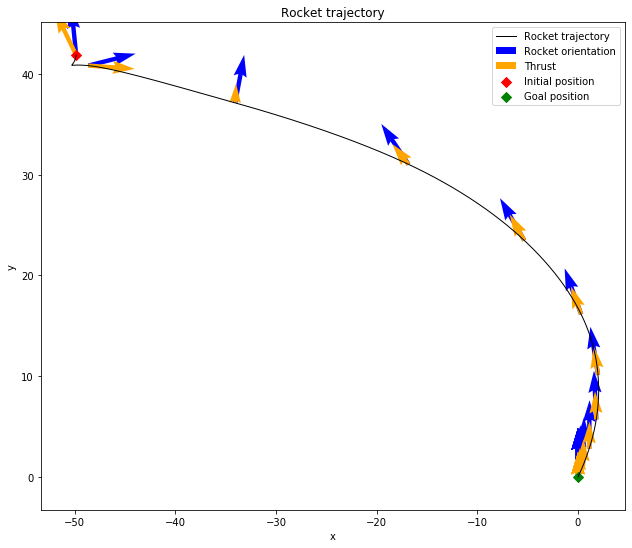

Starting to create LQR stabilization controller.
Finished creating LQR stabilization controller in 6.06 seconds.
Started simulation. Click `Stop Simulation` to stop.
Stopped simulation.


In [15]:
rocket_urdf = mk_rocket_urdf()

# visualize_urdf(rocket_urdf)

for i in range(1):
    logs, trajs = simulate(rocket_urdf, rate=1, timeout=15)
    if trajs:
        U_traj, X_traj = trajs
    state_log, control_log, unclipped_control_log = logs

In [ ]:
plt.title('x')
plt.plot(state_log.data()[0])
plt.show()

plt.title('y')
plt.plot(state_log.data()[1])
plt.show()

plt.title('theta')
plt.plot(state_log.data()[2])
plt.show()

plt.title('x, y')
plt.plot(state_log.data()[0], state_log.data()[1])
plt.plot([0], [0], color='k', marker='o')
c = 0.01
plt.xlim(-c, c)
plt.ylim(-c, c)
plt.show()

plt.title('u_mag')
plt.plot(unclipped_control_log.data()[0], label='unclipped')
plt.plot(control_log.data()[0], label='actual')
plt.legend()
plt.show()

plt.title('phi')
plt.plot(unclipped_control_log.data()[1], label='unclipped')
plt.plot(control_log.data()[1], label='actual')
plt.legend()
plt.show()

In [ ]:
X_opt = np.array([X_traj.value(t).squeeze() for t in np.arange(X_traj.start_time() + 0.5, X_traj.end_time(), 1)])
plt.plot(X_opt[:, 1])

In [ ]:
U_opt = np.array([U_traj.value(t).squeeze() for t in np.arange(X_traj.start_time(), X_traj.end_time(), 0.01)])
plt.plot(U_opt[:, 1])
plt.show()